In [138]:
import warnings
warnings.filterwarnings(action='ignore')

from glob import glob
import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

In [2]:
def load_data(file, sheet_name):
    return pd.read_excel(file, sheet_name=sheet_name)

In [3]:
def load_all_data():
    files = glob('/Users/sabin/Documents/Project/뉴스와 소셜데이터 기반 이슈 분석 및 시각화/Trend-analysis/dataset/임대차3법(54,752건)/*.xlsx')
    df = pd.DataFrame()
    for file in files:
        df = df.append(load_data(file, '블로그'))
    return df

blog = load_all_data()

## 블로그 Sheet

In [4]:
blog.isna().sum()

Unnamed: 0      0
Unnamed: 1      0
Unnamed: 2     33
Unnamed: 3    142
dtype: int64

In [5]:
blog.columns = blog.iloc[0]
blog.drop(0, inplace=True, axis=0)
blog = blog.dropna(axis=0, how='any')
blog = blog[~blog['내용'].str.contains('http')]
blog = blog[blog['내용'].str.contains('[가-힣]')]
blog = blog[blog['내용'].str.len() < 1000]

print(blog.shape)
blog.head()

(2224, 4)


,작성일,작성자,제목,내용
20,2020/07/28,hosabi55,"'임대차3법'에 ‘전월세대란’, ‘세입자불안’ 걱정하는듯 언론도 아무말대잔치","<0728 중도정론 표방 한국 기사 비교> \n'임대차3법'에 ‘전월세대란’, ‘세..."
46,2020/10/14,gg-bar,'민관협력 경기도 임대차3법 상담센터 설치' 업무협약을 체결 (20.09.22.),경기중앙지방변호사회는 정부의 임대차3법 시행에 따른 주택시장의 혼란을 최소화하기 위...
68,2020/07/26,namchuldo,[타박이] 임대차3법 계약갱신청구 거절 가능 사유에 집주인의 실거주 포함 예정,7/26/2020 처음 7/26/2020 \n \n7월26일 발표된 국토교통부의 ...
75,2020/11/11,chl3594,"대전 전세,월세 임대차3법 알아야!(2탄)","대전 전세,월세 계약시 \n임대차3법 알아야 후회없다(2탄) \n \n지난번 포스..."
102,2020/07/22,osanv,[현장의 소리]전세계약시 특약 넣어도 임대차3법 소급적용시 유효할까?,"결론부터 말하자면, \n임대차3법 피하려고 특약을 넣어도 소급적용시 효력이 없다. ..."


In [6]:
def tfdif(corpus):
    cv = CountVectorizer(ngram_range=(1, 2), max_features=1000)
    document_term_matrix = cv.fit_transform(corpus)

    tf = pd.DataFrame(document_term_matrix.toarray(), columns=cv.get_feature_names())  # TF (Term Frequency)

    D = len(tf)
    df = tf.astype(bool).sum(axis=0)
    idf = np.log((D+1) / (df+1)) + 1             # IDF (Inverse Document Frequency)

    # TF-IDF (Term Frequency-Inverse Document Frequency)
    tfidf = tf * idf                      
    tfidf = tfidf / np.linalg.norm(tfidf, axis=1, keepdims=True)
    
    return tfidf


'<0728 중도정론 표방 한국 기사 비교> \n\'임대차3법\'에 ‘전월세대란’, ‘세입자불안’ 걱정하는듯 언론도 아무말대잔치 \n-보수는 ‘전월세대란’ 초래 졸속추진 비판, 진보는 ‘세입자불안’ 해소 신속처리 주문 \n-주택공급대책에도 임대주택에 대한 의견 분분 \n*한국 5면 기사는 주택공급대책의 긍부정 측면 해설과 임대차3법 팩트 전달 \n-사설은 임대차 3법에 대한 찬반 거론않고 장기임대 늘릴 것을 강조 \n중앙 만평 \n<\'임대차 3법\' 추진, 주택공급대책 관련 사설> \n한국: 주택 공급 대책, 장기임대 획기적으로 늘리길  \n동아: 끓는 전세시장에 기름 붓는 임대차 법안, ‘주거대란’ 부른다 \n한겨레: \'임대차 3법\' 신속 처리로 세입자 불안 덜어줘야 \n세계: 임대차 3법 졸속 추진…전월세 대란 우려된다 \n<\'임대차 3법\' 추진, 주택공급대책 관련 메인 기사> \n한국 5면 톱: 정부, 용적률·층수 규제 완화 추진... "디테일 못 살리면 혼란" \n가닥잡히는 임대차 3법... "2+2년에 인상률 5% 범위 내 결정" \n조선 1면: 법무부, 전세 2+2년에 인상률 5%로 제한 추진 \n6면 톱: 용적률100%p 올리면 3만가구… 다른규제 많아 실효성 의문 \n중앙 1면: 임대차 3법 상정된 날, 과천 전세 8억 찍었다 \n동아 1면: “전월세 계약 2+2년, 인상률 5%내 제한… 기존계약도 소급적용” \n5면: “재건축 들썩일라”… 정부, 용적률 딜레마  \n경향 3면 톱: 묘수 찾다 ‘용적률 상향’카드 추가…재건축 특혜시비 우려 \n한겨례 6면: “로또 된 공공분양…불로소득 최소화 뾰족수 찾아라” \n‘임대차 3법’ 윤곽…“임대차 2+2년, 인상률은 5%내 지자체 결정”'

## Key phrase
* ngram_range=(2,5)

In [92]:
def tfidf_key_phrase(ngram_range=(2,5), max_features=1000):
    vocab = {}
    tfidf = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    
    for content in blog['내용']:
        if len(content) < 500:
            continue
        new_tfidf = tfidf.fit_transform(content.split(','))
        new_tfidf = new_tfidf.toarray()
        new_tfidf = pd.DataFrame(new_tfidf, columns=tfidf.get_feature_names())
        new_tfidf = new_tfidf.sum(axis=0).sort_values(ascending=False)[:10]
        for key, value in new_tfidf.items():
            if key in vocab:
                vocab[key] += value
            else:
                vocab[key] = value
        
    return vocab

In [112]:
vocab = tfidf_key_phrase(ngram_range=(2,4))

In [113]:
vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
vocab[:10]

[('전월세 상한제', 22.563676866440012),
 ('임대차 3법', 19.735821626701345),
 ('출처 unsplash', 6.3569887581902),
 ('전월세 신고제', 6.334777469291891),
 ('착공에 한번', 4.0),
 ('뒷구녕 아빠', 4.0),
 ('엔은 105', 4.0),
 ('임대차 계약', 3.7012475241128397),
 ('내용증명 대필전문', 3.404936297151525),
 ('pmg 지식엔진연구소', 3.0)]

In [137]:
with open('tfdif_vocab_keyphrase.json', 'w') as f:
    json.dump(vocab, f)

(-0.5, 799.5, 599.5, -0.5)

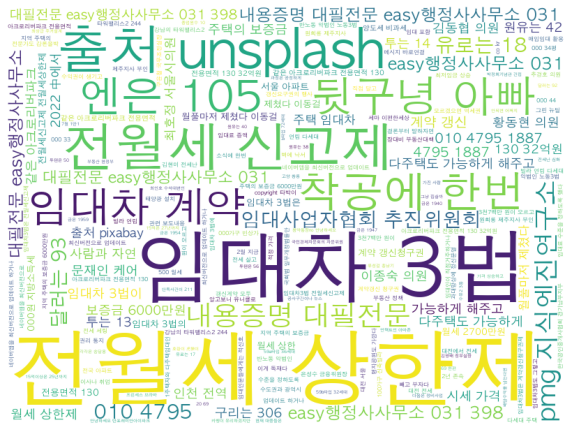

In [124]:
wordcloud = WordCloud(background_color='white', width=800, height=600, font_path='/Library/Fonts/AppleGothic.ttf').generate_from_frequencies(dict(vocab))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')

In [135]:
wordcloud.to_file('tfidf_wordcloud_keyphrase.png')

## Key Word

In [126]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)

new_tfidf = tfidf.fit_transform(blog['내용'][20].split(','))
new_tfidf = new_tfidf.toarray()

In [127]:
new_tfidf = pd.DataFrame(new_tfidf, columns=tfidf.get_feature_names())
new_tfidf

,0728,0728 중도정론,1면,1면 법무부,1면 임대차,1면 전월세,2년,2년에,2년에 인상률,3만가구,...,한국 기사,한국 주택,해설과,해설과 임대차3법,해소,해소 신속처리,혼란,혼란 가닥잡히는,획기적으로,획기적으로 늘리길
0,0.270116,0.270116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.270116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.122995,0.122995,0.122995,0.122995,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.292282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.236905,0.236905
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.137935,0.180376,0.000000,0.000000,0.000000,0.155550,0.155550,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180376,0.180376,0.000000,0.000000
8,0.000000,0.000000,0.139694,0.000000,0.182676,0.000000,0.000000,0.157533,0.157533,0.182676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.193865,0.000000,0.000000,0.253514,0.218622,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


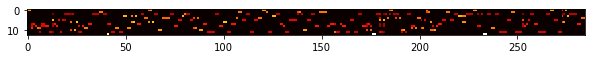

In [128]:
plt.figure(figsize=(10, 10))
plt.imshow(new_tfidf, cmap='hot', interpolation='nearest')
plt.show()


In [130]:
keyword = new_tfidf.sum(axis=0).sort_values(ascending=False)
keyword[:20]

임대차          0.917750
임대차 3법       0.686326
3법           0.686326
한국           0.684610
결정           0.551493
추진           0.548925
5면           0.540734
관련           0.517912
주택공급대책       0.517912
주택공급대책 관련    0.517912
정부           0.503720
기사           0.498797
인상률          0.488554
1면           0.471493
지자체 결정       0.459137
지자체          0.459137
인상률은         0.459137
인상률은 지자체     0.459137
전월세대란        0.445318
동아           0.422920
dtype: float64

In [141]:
with open('tfdif_keyword.json', 'w') as f:
    json.dump(keyword.to_list(), f)

(-0.5, 799.5, 599.5, -0.5)

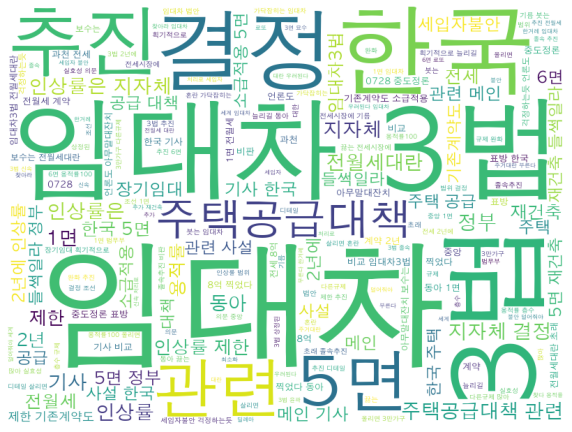

In [132]:
wordcloud = WordCloud(background_color='white', width=800, height=600, font_path='/Library/Fonts/AppleGothic.ttf').generate_from_frequencies(dict(keyword))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')

In [134]:
wordcloud.to_file('tfidf_wordcloud_keyword.png')

# TFDIF

We couldn't figure the relationship between the words linearly

as we can see in the graph above